In [1]:
from rasterio.plot import show
from rasterio.plot import show_hist
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import seaborn as sns
import rasterio
import numpy as np
from xml.dom import minidom
import cv2
import dask.array as da
import dask.dataframe as dd
from dask.distributed import Client
%matplotlib inline

In [2]:
# client = Client(dashboard_address='10.10.27.71:8787')  # start distributed scheduler locally.

In [3]:
# filename = './data/analytic/analytic_8b_sr_udm2/20221022_152926_36_241b_3B_AnalyticMS_SR_8b.tif'
filename = './data/analytic/small.tif'
src = rasterio.open(filename)

## 2. Look at the Data

Bands in the PSScene 8-band files are in the following order:  
1. coastal_blue
2. blue
3. green_i
4. green
5. yellow
6. red
7. red_edge
8. nir


### To DO:
create TOA bands  
compare to normalized  
compare to regular stats  


In [4]:
n_bands = src.meta['count']
img_shape = src.shape
src.meta


{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 0.0,
 'width': 2874,
 'height': 1874,
 'count': 8,
 'crs': CRS.from_epsg(32616),
 'transform': Affine(3.0, 0.0, 271998.0,
        0.0, -3.0, 2070528.0)}

In [5]:
array = src.read()

stats = []
for idx, band in enumerate(array):
    stats.append({
        'band_number': idx + 1,
        'min': band.min(),
        'mean': band.mean(),
        'median': np.median(band),
        'max': band.max(),
        'std': int(np.std(band)),
        'var': int(np.var(band)),
        'vmin': int(band.mean() - np.std(band)),
        'vmax': int(band.mean() + np.std(band)),
    })

In [6]:
# stats

Text(0.5, 1.0, 'nir')

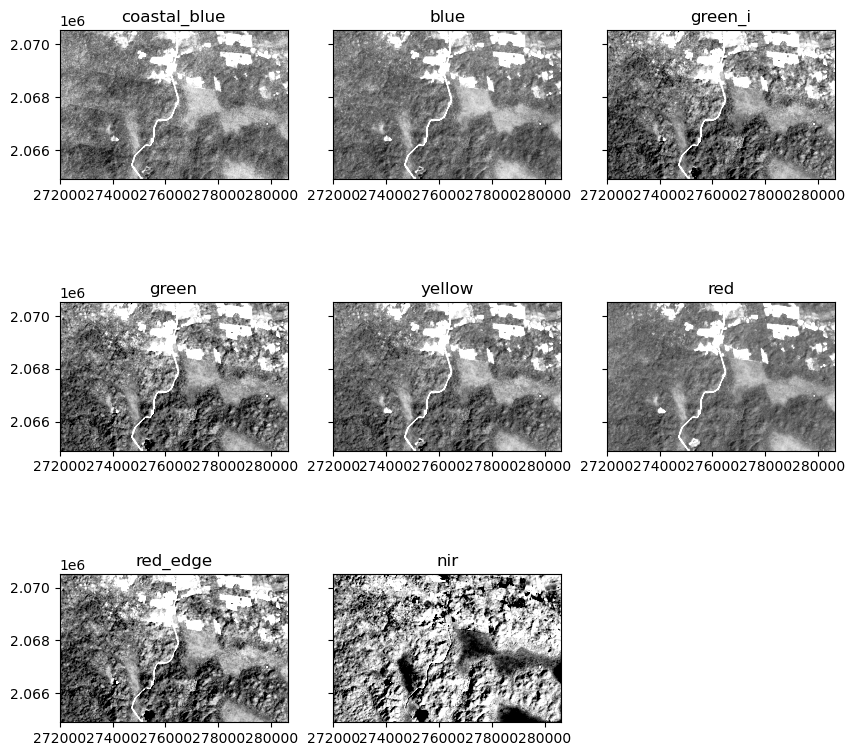

In [7]:
# Initialize subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10), sharey=True)

ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9 = axes.flatten()

fig.delaxes(ax9)

# plots
show((src, 1), cmap='Greys_r', ax=ax1, vmin=stats[0]['vmin'], vmax=stats[0]['vmax'])
show((src, 2), cmap='Greys_r', ax=ax2, vmin=stats[1]['vmin'], vmax=stats[1]['vmax'])
show((src, 3), cmap='Greys_r', ax=ax3, vmin=stats[2]['vmin'], vmax=stats[2]['vmax'])
show((src, 4), cmap='Greys_r', ax=ax4, vmin=stats[3]['vmin'], vmax=stats[3]['vmax'])
show((src, 5), cmap='Greys_r', ax=ax5, vmin=stats[4]['vmin'], vmax=stats[4]['vmax'])
show((src, 6), cmap='Greys_r', ax=ax6, vmin=stats[5]['vmin'], vmax=stats[5]['vmax'])
show((src, 7), cmap='Greys_r', ax=ax7, vmin=stats[6]['vmin'], vmax=stats[6]['vmax'])
show((src, 8), cmap='Greys_r', ax=ax8, vmin=stats[7]['vmin'], vmax=stats[7]['vmax'])

# add titles
ax1.set_title('coastal_blue')
ax2.set_title('blue')
ax3.set_title('green_i')
ax4.set_title('green')
ax5.set_title('yellow')
ax6.set_title('red')
ax7.set_title('red_edge')
ax8.set_title('nir')

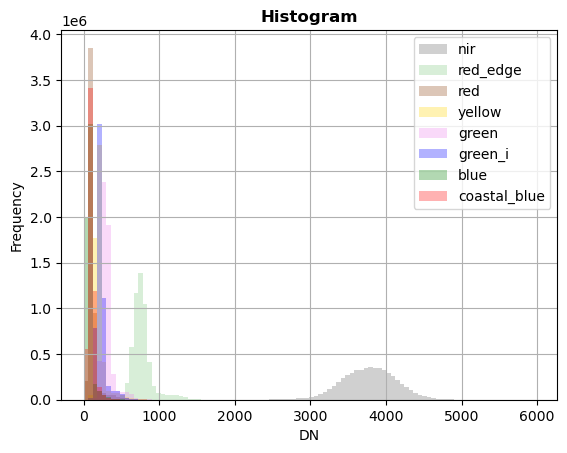

In [8]:
labels = ['coastal_blue',
          'blue',
          'green_i',
          'green',
          'yellow',
          'red',
          'red_edge',
          'nir']

show_hist(src, bins=100, lw=0.0, stacked=False, alpha=0.3, label=labels,
          histtype='stepfilled', title="Histogram")

In [9]:
# Read the grid values into dask/numpy arrays
coastal_blue_sr = da.from_array(src.read(1))
blue_sr = da.from_array(src.read(2))
green_i_sr = da.from_array(src.read(3))
green_sr = da.from_array(src.read(4))
yellow_sr = da.from_array(src.read(5))
red_sr = da.from_array(src.read(6))
red_edge_sr = da.from_array(src.read(7))
nir_sr = da.from_array(src.read(8))

# Function to normalize the grid values
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

In [10]:
# Normalize the bands
nirn = normalize(nir_sr)
redn = normalize(red_sr)
greenn = normalize(green_sr)
bluen = normalize(blue_sr)

# print("Normalized bands")
# print(nirn.min(), '-', nirn.max(), 'mean:', nirn.mean())
# print(redn.min(), '-', redn.max(), 'mean:', redn.mean())
# print(greenn.min(), '-', greenn.max(), 'mean:', greenn.mean())
# print(bluen.min(), '-', bluen.max(), 'mean:', bluen.mean())

In [11]:
nirn

dask.array<truediv, shape=(1874, 2874), dtype=float64, chunksize=(1874, 2874), chunktype=numpy.ndarray>

In [12]:
# Normalize the bands
nirn = normalize(nir_sr).compute()
redn = normalize(red_sr).compute()
greenn = normalize(green_sr).compute()
bluen = normalize(blue_sr).compute()

In [13]:
nirn

array([[0.64990926, 0.64337568, 0.65045372, ..., 0.6845735 , 0.6491833 ,
        0.65117967],
       [0.64373866, 0.63448276, 0.6261343 , ..., 0.68475499, 0.65517241,
        0.66297641],
       [0.63738657, 0.6199637 , 0.6061706 , ..., 0.67622505, 0.66823956,
        0.67332123],
       ...,
       [0.58076225, 0.57205082, 0.5707804 , ..., 0.51705989, 0.52649728,
        0.52813067],
       [0.55735027, 0.56116152, 0.58076225, ..., 0.50362976, 0.51578947,
        0.53139746],
       [0.52577132, 0.55735027, 0.6       , ..., 0.49891107, 0.52068966,
        0.53720508]])

In [14]:
# create TOA bands
xmldoc = minidom.parse('./data/analytic/analytic_8b_sr_udm2/20221022_152926_36_241b_3B_AnalyticMS_8b_metadata.xml')
nodes = xmldoc.getElementsByTagName("ps:bandSpecificMetadata")

# XML parser refers to bands by numbers 1-8
coeffs = {}
for node in nodes:
    bn = node.getElementsByTagName("ps:bandNumber")[0].firstChild.data
    if bn in ['1', '2', '3', '4', '5', '6', '7', '8']:
        i = int(bn)
        value = node.getElementsByTagName("ps:reflectanceCoefficient")[0].firstChild.data
        coeffs[i] = float(value)

# print(coeffs)
        
# Multiply the Digital Number (DN) values in each band by the TOA reflectance coefficients
coastal_blue_toa = (coastal_blue_sr * coeffs[1]).compute()
blue_toa = (blue_sr * coeffs[2]).compute()
green_i_toa = (green_i_sr * coeffs[3]).compute()
green_toa = (green_sr * coeffs[4]).compute()
yellow_toa = (yellow_sr * coeffs[5]).compute()
red_toa = (red_sr * coeffs[6]).compute()
red_edge_toa = (red_sr * coeffs[7]).compute()
nir_toa = (nir_sr * coeffs[8]).compute()


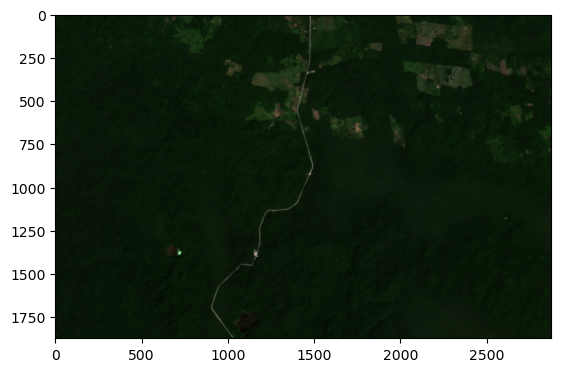

In [15]:
# Create RGB natural color composite from normalized SR values
rgb = da.dstack((redn, greenn, bluen))
rgb.compute()

# Let's see how our color composite looks like
plt.imshow(rgb)


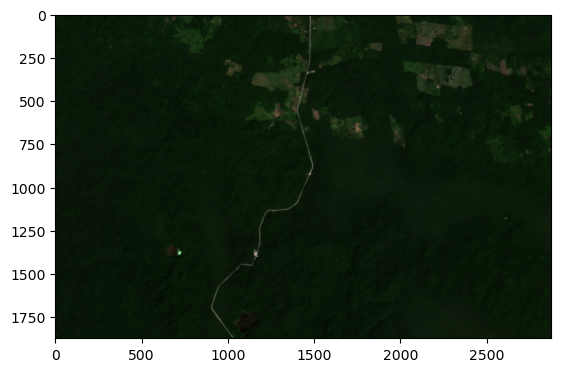

In [16]:
# Create RGB natural color composite from TOA values
red_toa
red_toa_n = normalize(red_toa)
green_toa_n = normalize(green_toa)
blue_toa_n = normalize(blue_toa)

rgb_toa = da.dstack((red_toa_n, green_toa_n, blue_toa_n))
rgb_toa.compute()

# Let's see how our color composite looks like
plt.imshow(rgb_toa)

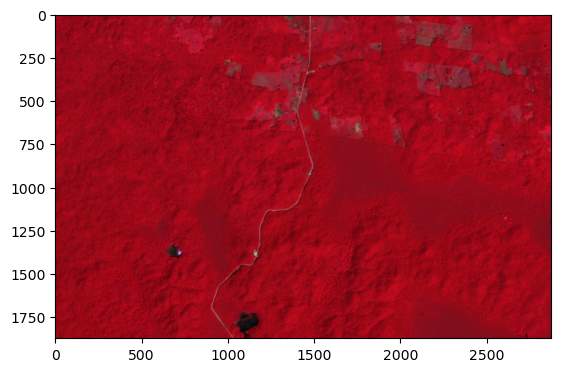

In [17]:
# Create the composite by stacking
nrg = np.dstack((nirn, redn, greenn))

# Let's see how our color composite looks like
plt.imshow(nrg)

In [18]:
# Allow division by zero
np.seterr(divide='ignore', invalid='ignore')

# Calculate NDVI.
ndvi = (nir_toa.astype(float) - red_toa.astype(float)) / (nir_toa + red_toa)

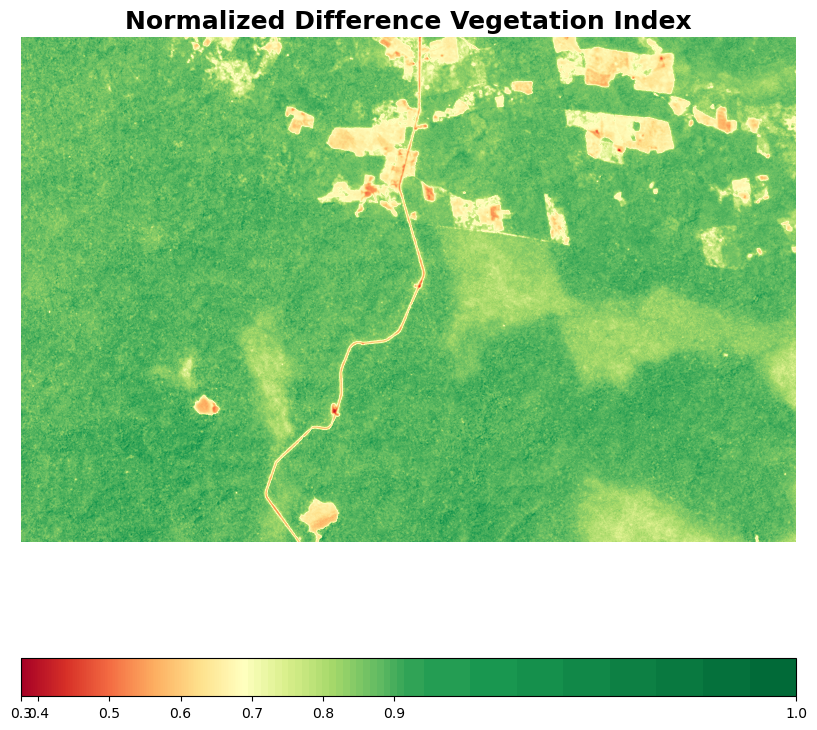

In [19]:

class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    Credit: Joe Kington, http://chris35wills.github.io/matplotlib_diverging_colorbar/
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))


# Set min/max values from NDVI range for image (excluding NAN)
# set midpoint according to how NDVI is interpreted: https://earthobservatory.nasa.gov/Features/MeasuringVegetation/
min=np.nanmin(ndvi)
max=np.nanmax(ndvi)
mid=0.92

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

# diverging color scheme chosen from https://matplotlib.org/users/colormaps.html
cmap = plt.cm.RdYlGn 

cax = ax.imshow(ndvi, cmap=cmap, clim=(min, max), norm=MidpointNormalize(midpoint=mid,vmin=min, vmax=max))

ax.axis('off')
ax.set_title('Normalized Difference Vegetation Index', fontsize=18, fontweight='bold')

cbar = fig.colorbar(cax, orientation='horizontal')

fig.savefig("./output/ndvi-fig.png", dpi=200, bbox_inches='tight', pad_inches=0.7)

plt.show()

In [20]:

# 3 dimensional dummy array with zeros
MB_img = da.zeros((img_shape[0], img_shape[1], n_bands))

# stacking up images into the array
for i in range(n_bands):
    # MB_img[:,:,i] = cv2.imread('band'+str(i+1)+'.jpg', cv2.IMREAD_GRAYSCALE)  
    MB_img[:,:,i] = src.read(i+1)

# Convert 2d band array in 1-d to make them as feature vectors and Standardization
MB_matrix = da.zeros((MB_img[:,:,0].size,n_bands))

for i in range(n_bands):
    MB_array = MB_img[:,:,i].flatten()  # covert 2d to 1d array 
    MB_arrayStd = (MB_array - MB_array.mean())/MB_array.std()  
    MB_matrix[:,i] = MB_arrayStd

# MB_matrix.shape
MB_matrix.compute()

array([[ 0.38970532, -0.4250492 ,  0.64860022, ..., -0.36857925,
         1.11762673,  0.72037385],
       [ 0.10722608, -0.44434078,  0.62084497, ..., -0.32129706,
         0.71762209,  0.62701846],
       [-0.13489898,  0.1922814 ,  0.30165964, ..., -0.07306554,
         0.53516383,  0.72815346],
       ...,
       [ 0.67218457,  0.25015614,  0.32941489, ...,  0.26973036,
        -0.14554582, -1.43717288],
       [ 0.99501799,  0.32732247,  0.31553727, ...,  0.08060159,
         0.05094768, -1.12598825],
       [ 0.08704899,  0.2887393 ,  0.31553727, ...,  0.15152487,
         0.20533544, -0.89000658]])

In [21]:
# Covariance
np.set_printoptions(precision=3)
cov = np.cov(MB_matrix.transpose())

# Eigen Values
EigVal,EigVec = np.linalg.eig(cov)

print("Eigenvalues:\n\n", EigVal,"\n")

/data/code/jaguar/env/lib/python3.10/site-packages/dask/array/core.py:1638: FutureWarning: The `numpy.linalg.eig` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


Eigenvalues:

 [6.152 1.17  0.354 0.147 0.033 0.029 0.061 0.053] 



In [22]:
# Ordering Eigen values and vectors
order = EigVal.argsort()[::-1]
EigVal = EigVal[order]
EigVec = EigVec[:,order]

#Projecting data on Eigen vector directions resulting to Principal Components 
PC = np.matmul(MB_matrix,EigVec)   #cross product
PC.compute()

array([[ 8.383e-01,  1.117e+00, -1.326e-03, ..., -3.781e-02,  4.603e-02,
         6.359e-02],
       [ 7.950e-01,  1.007e+00,  2.542e-01, ...,  3.637e-01, -2.061e-01,
        -1.509e-01],
       [ 7.051e-01,  8.816e-01,  2.248e-01, ..., -2.933e-02, -2.129e-01,
        -1.166e-01],
       ...,
       [ 4.572e-01, -1.505e+00, -8.913e-02, ...,  9.582e-02,  2.309e-01,
        -9.206e-02],
       [ 8.547e-01, -1.239e+00, -3.208e-01, ...,  1.009e-01, -2.079e-01,
         1.513e-01],
       [ 4.397e-01, -8.209e-01,  3.398e-01, ..., -1.023e-01,  8.044e-02,
         2.281e-01]])

Text(0.5, 0.98, 'Pair plot of PCs')

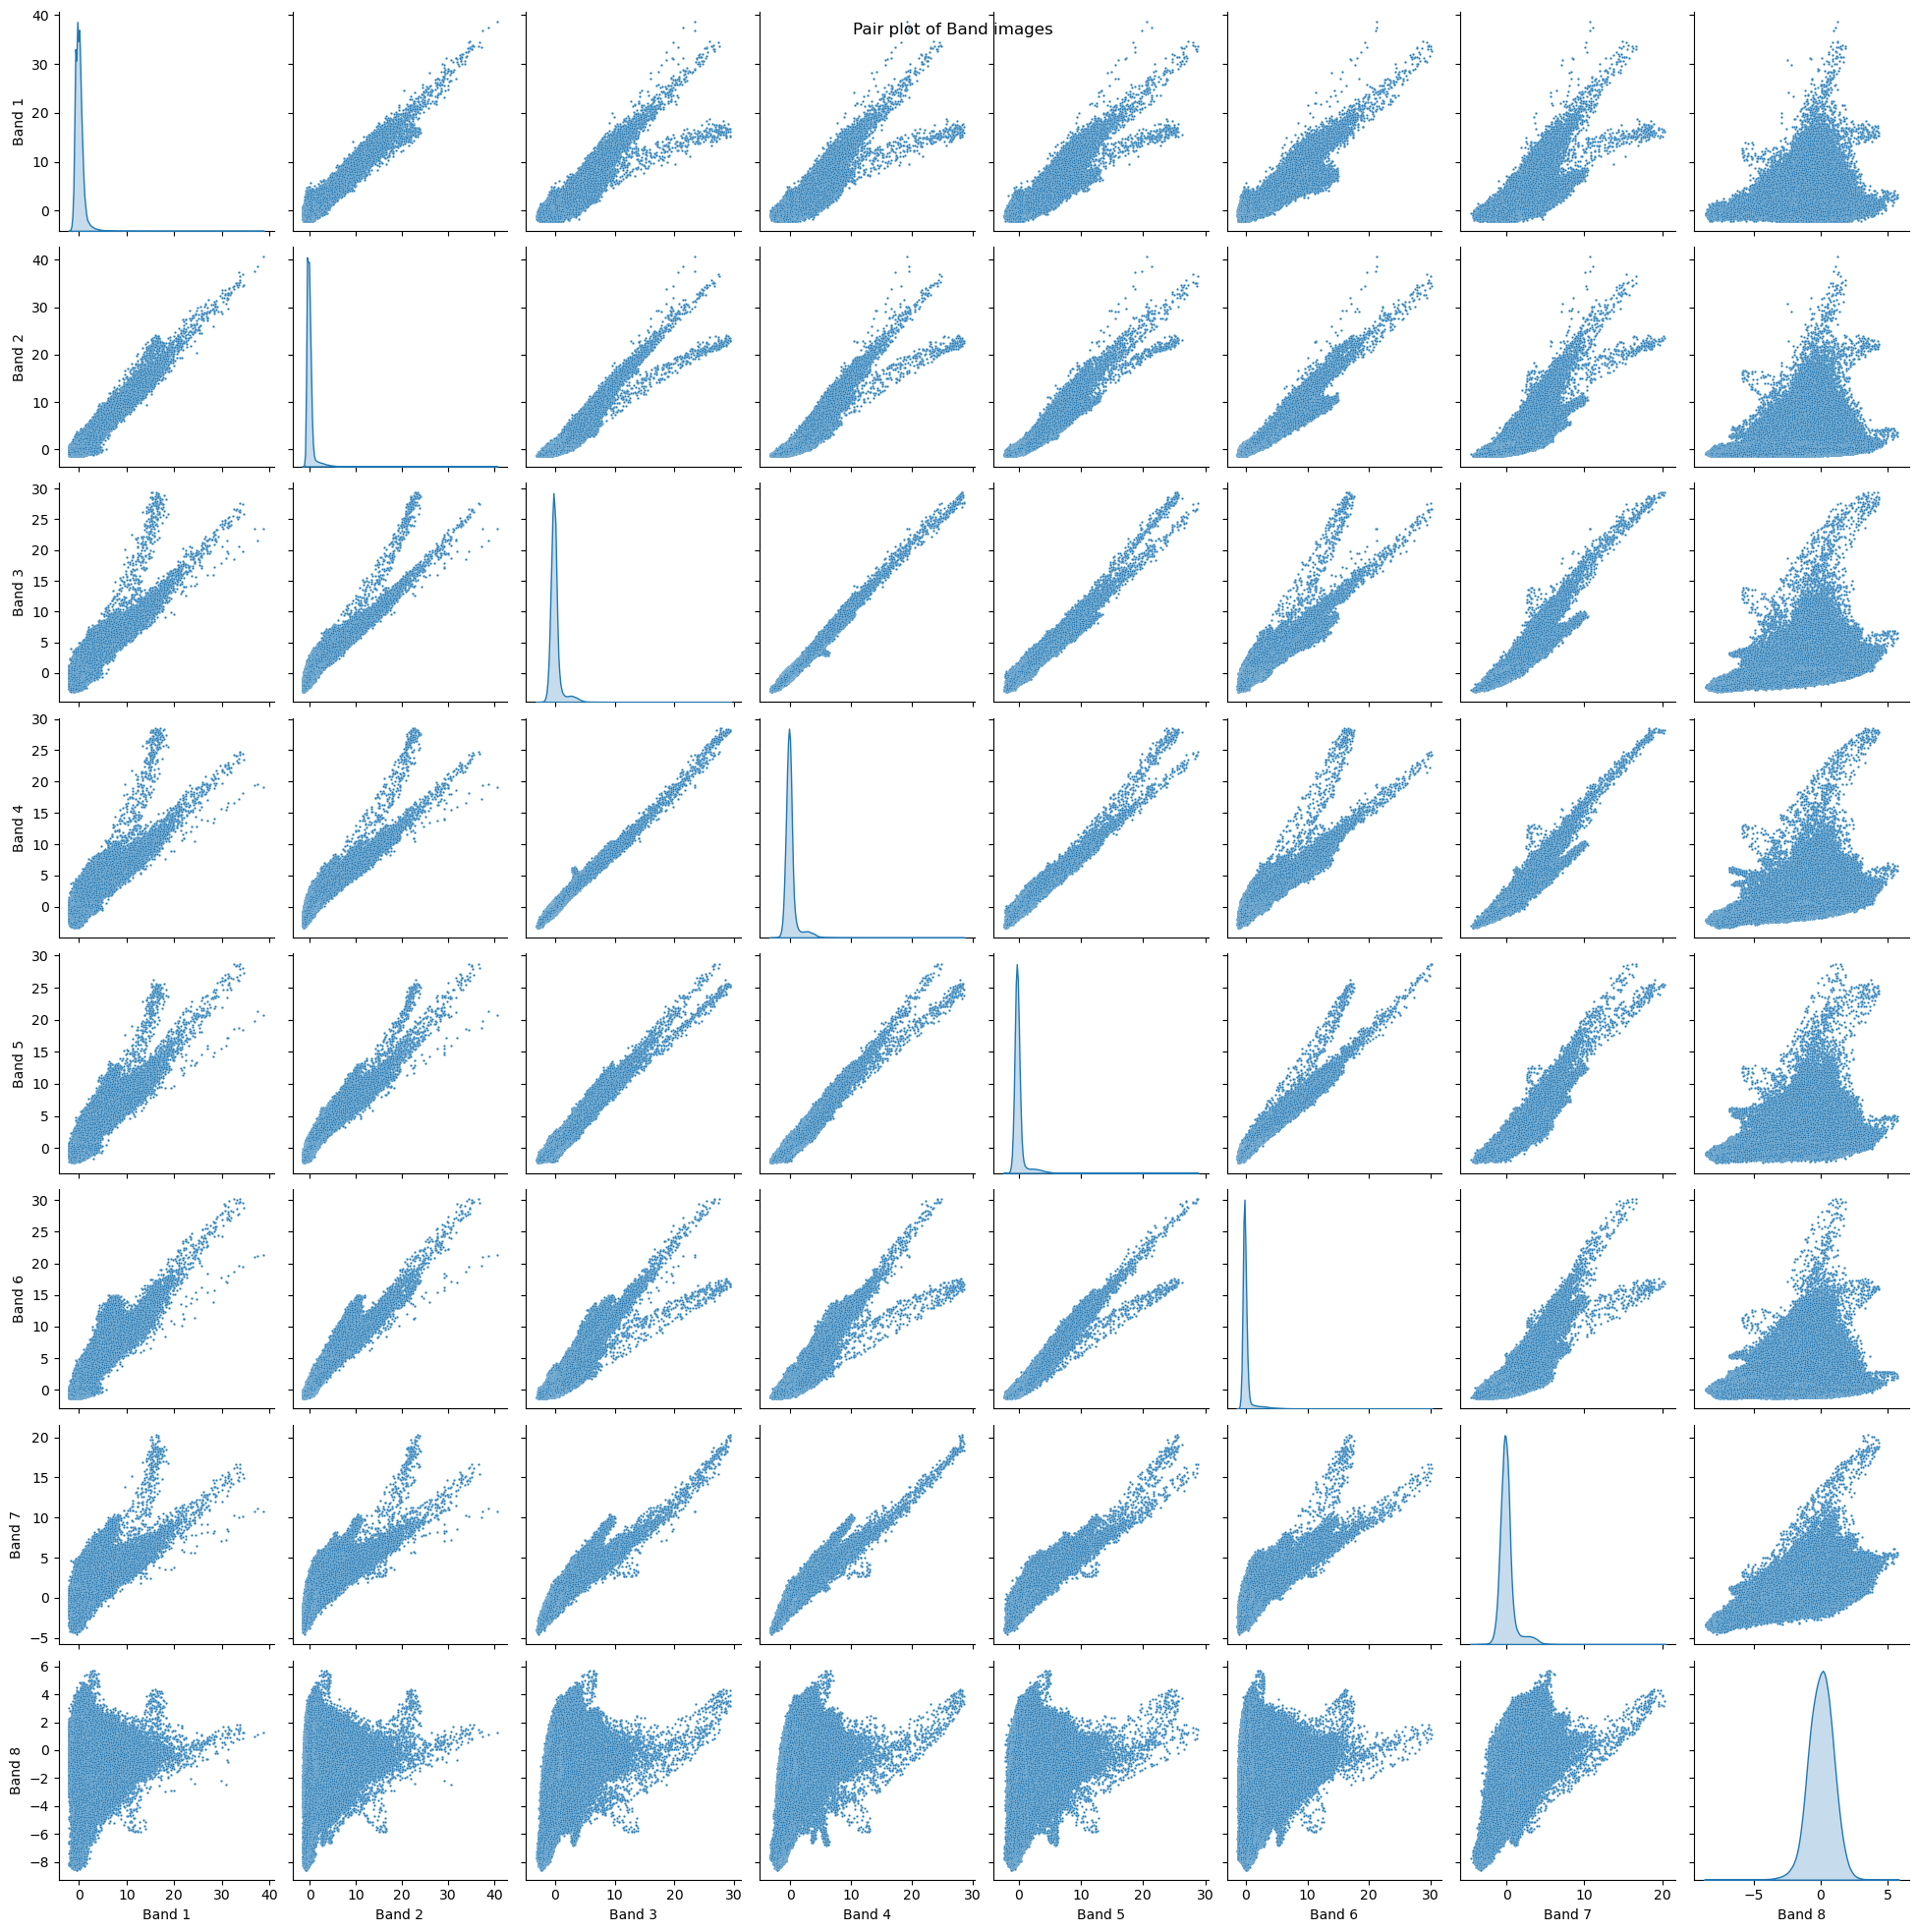

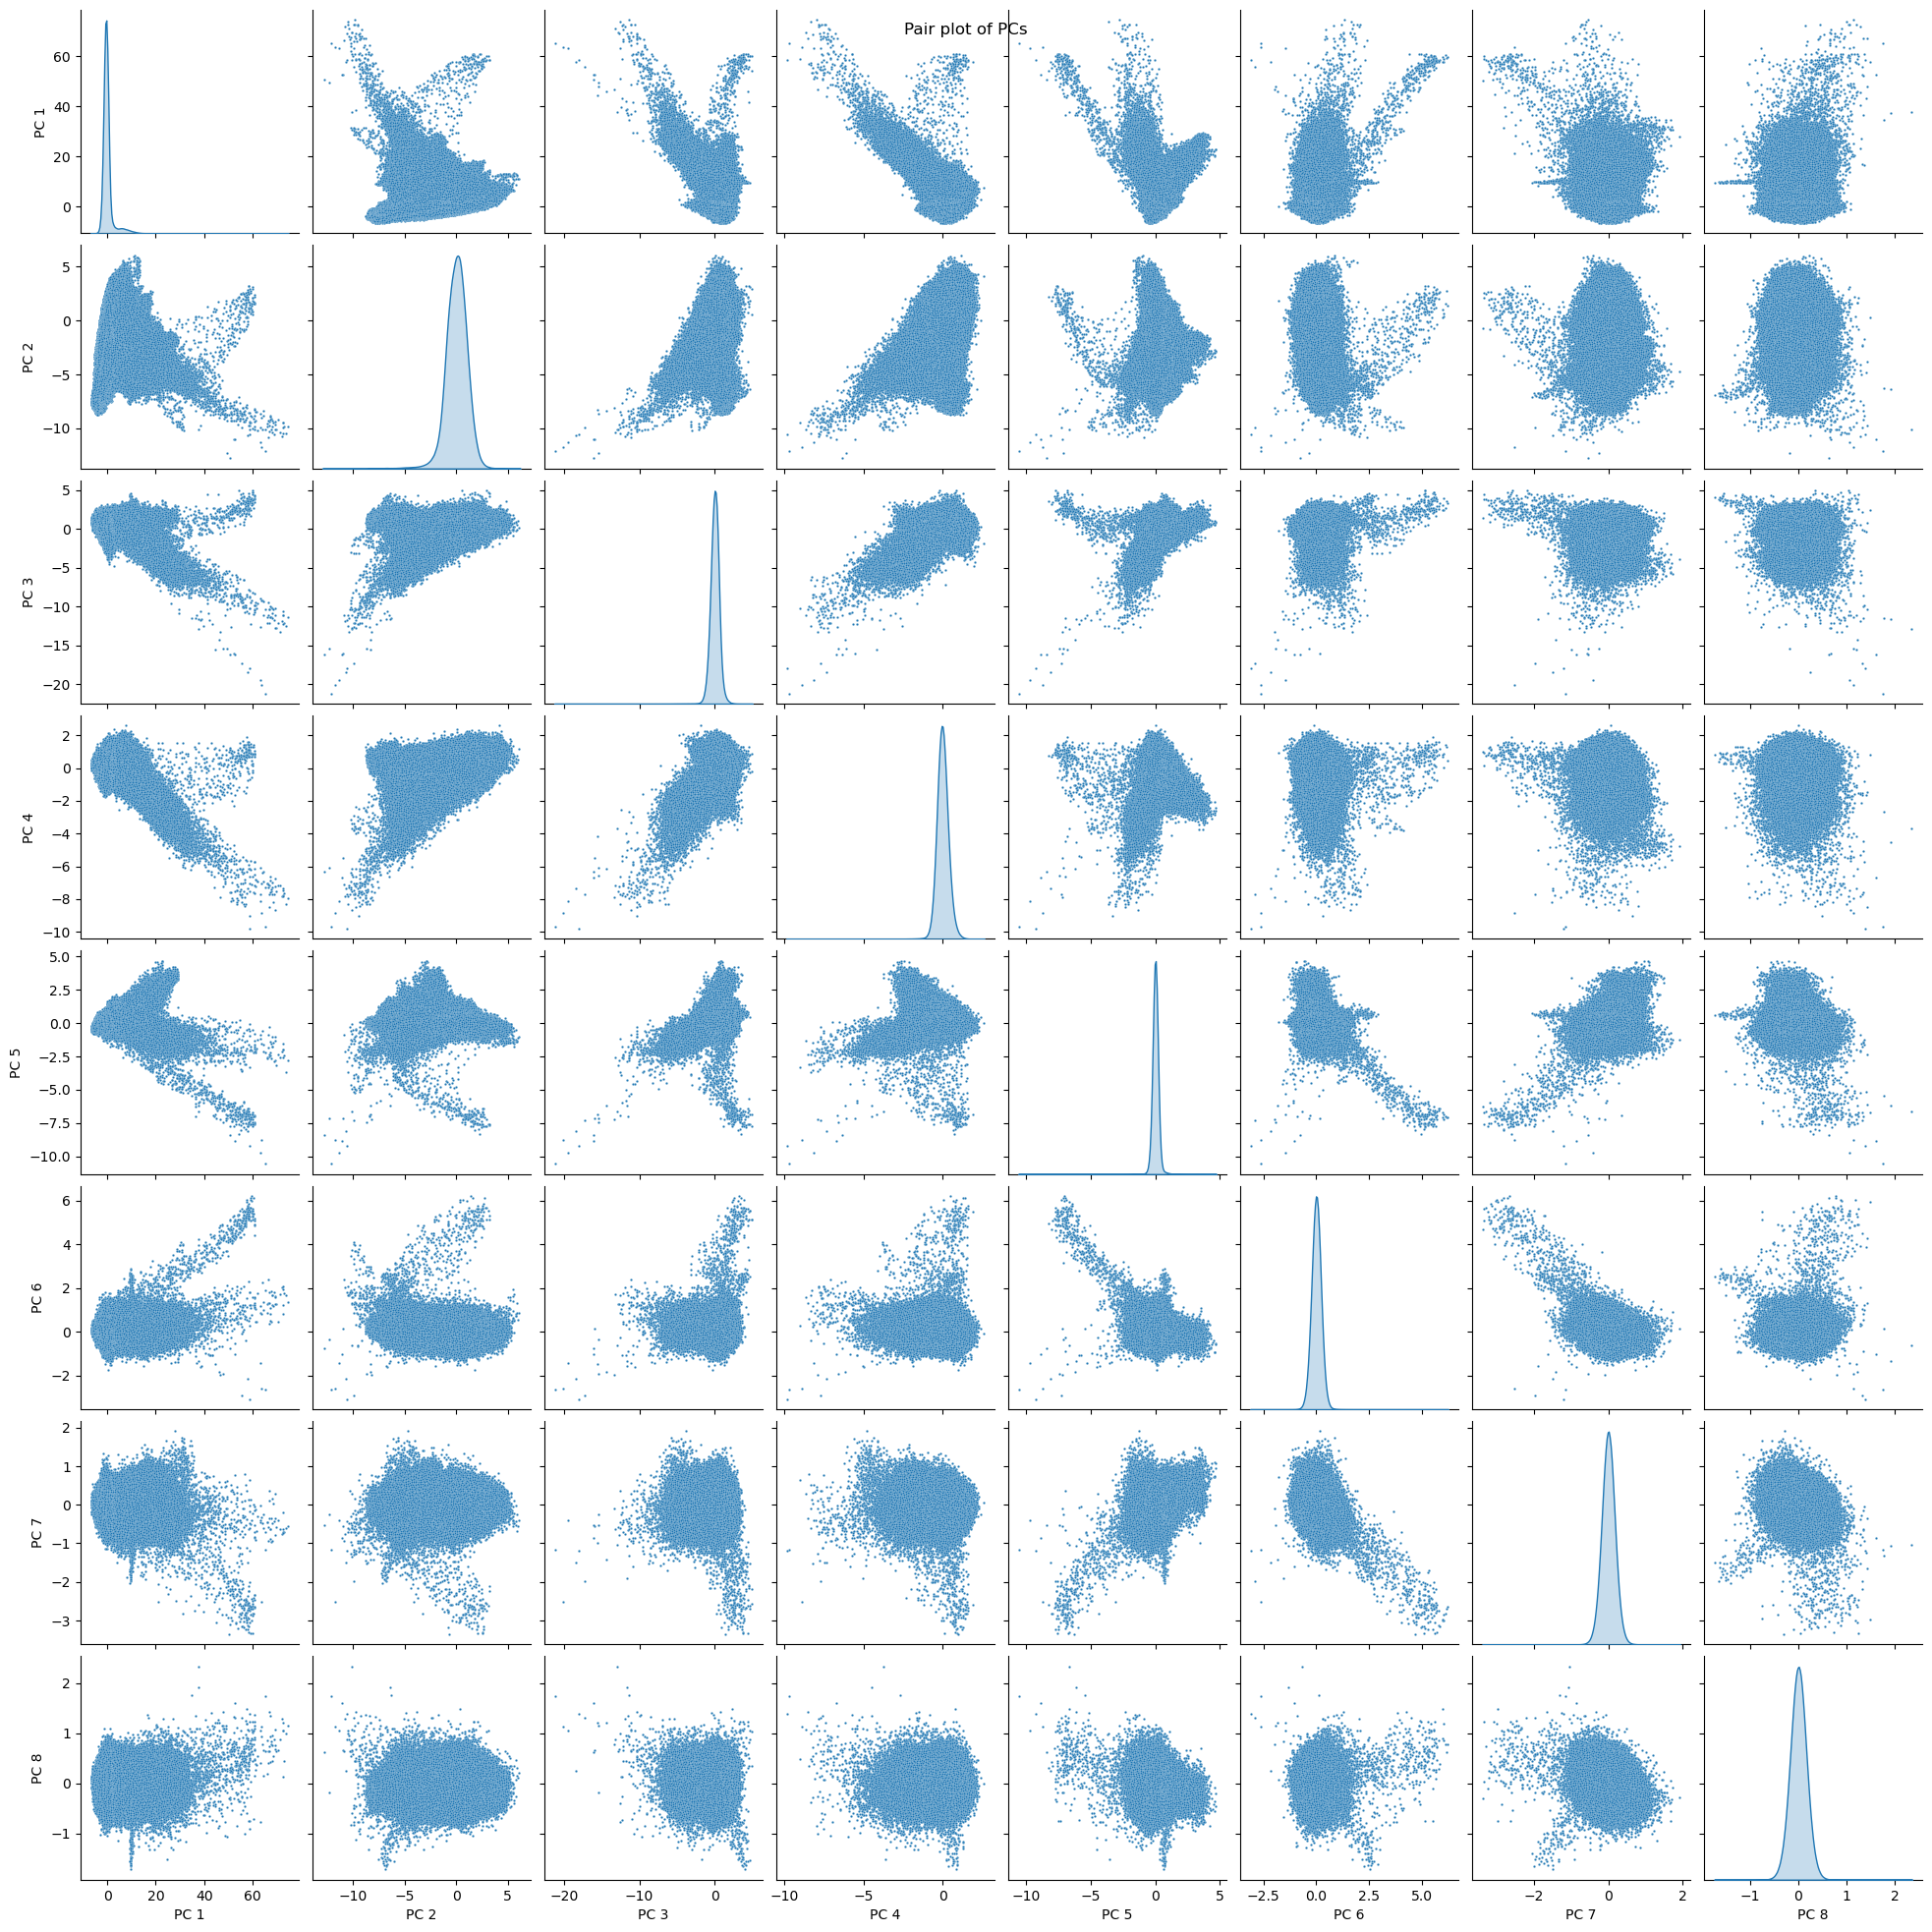

In [23]:

Bandnames = ['Band 1', 'Band 2', 'Band 3', 'Band 4',
             'Band 5', 'Band 6', 'Band 7', 'Band 8']

df = pd.DataFrame(
    MB_matrix,
    columns=Bandnames)
    
# dask_df = dd.from_pandas(df)
# dask_df.compute()

a = sns.pairplot(df,
                 diag_kind='kde',
                 plot_kws={"s": 3})

a.fig.suptitle("Pair plot of Band images")

PCnames = ['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7', 'PC 8']

b = sns.pairplot(pd.DataFrame(PC, columns=PCnames),
                 diag_kind='kde',
                 plot_kws={"s": 3})

b.fig.suptitle("Pair plot of PCs")

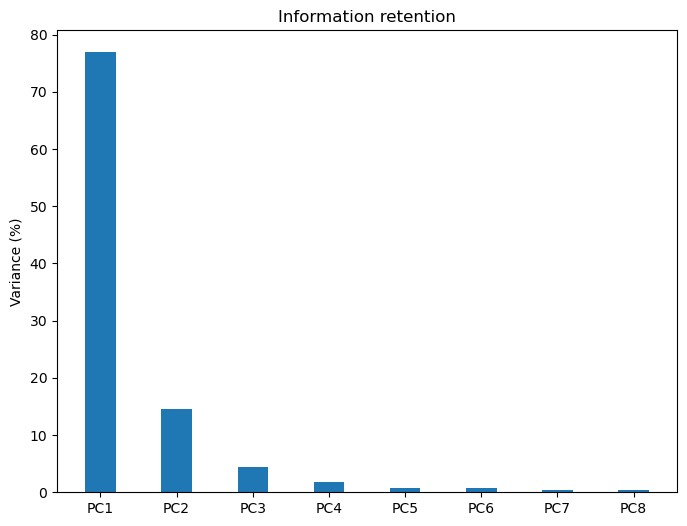

In [24]:
plt.figure(figsize=(8,6))
plt.bar([1,2,3,4,5,6,7,8],EigVal/sum(EigVal)*100,align='center',width=0.4,
        tick_label = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7', 'PC8'])
plt.ylabel('Variance (%)')
plt.title('Information retention');

In [25]:
PC_2d = da.zeros((img_shape[0],img_shape[1],n_bands))

for i in range(n_bands):
    PC_2d[:,:,i] = PC[:,i].reshape(-1,img_shape[1])

# normalizing between 0 to 255
PC_2d_Norm = da.zeros((img_shape[0],img_shape[1],n_bands))

for i in range(n_bands):
    PC_2d_Norm[:,:,i] = cv2.normalize(PC_2d[:,:,i], np.zeros(img_shape),0,1023 ,cv2.NORM_MINMAX)

error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'normalize'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


In [ ]:
fig,axes = plt.subplots(2, 4, 
                        figsize=(50,23), 
                        sharex='all',
                        sharey='all')

fig.subplots_adjust(wspace=0.1, hspace=0.15)

fig.suptitle('Intensities of Principal Components ', fontsize=30)

axes = axes.ravel()

for i in range(n_bands):
    axes[i].imshow(PC_2d_Norm[:,:,i],cmap='gray', vmin=0, vmax=255)
    axes[i].set_title('PC '+str(i+1),fontsize=25)
    axes[i].axis('off')


In [ ]:

# Comparsion of RGB and Image produced using first three bands
fig,axes = plt.subplots(1, 2, 
                        figsize=(50,23),
                        sharex='all', 
                        sharey='all')   

fig.subplots_adjust(wspace=0.1, hspace=0.15)

axes[0].imshow(MB_img[:,:,[1, 3, 5]].astype(int))
axes[0].axis('off');

axes[1].imshow(PC_2d_Norm[:,:,:3][:,:,[0, 1, 2]].astype(int))
axes[1].axis('off');

In [ ]:
# Set spatial characteristics of the output object to mirror the input
kwargs = src.meta
kwargs.update(
    dtype=rasterio.float32,
    count = 8)

# print(kwargs)
# print(PC_2d_Norm.shape)

# band, row, col
# PC_2d_Norm_reshape = np.moveaxis(PC_2d_Norm, [0, 1, 2], [2, 1, 0]) 
foo = np.moveaxis(PC_2d_Norm, [0, 1, 2], [2, 1, 0]) 
PC_2d_Norm_reshape = np.swapaxes(foo, 1, 2)

print(PC_2d_Norm_reshape.shape)
        
# Write band calculations to a new raster file
with rasterio.open('output/pca.tif', 'w', **kwargs) as dst:
        dst.write(PC_2d_Norm_reshape.astype(rasterio.float32))


In [ ]:
# client.shutdown()